In [50]:
import scanpy as sc
import scvi
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
adata = sc.read_h5ad('/nfs_master/prakrithi/abhay/testis_allfiles/GSE112013_SRR6860519_Donor1_rep1.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 10000 × 58389

# Doublet Removal

In [4]:
sc.pp.filter_genes(adata, min_cells = 10)

In [5]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')


In [6]:
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████| 400/400 [05:32<00:00,  1.20it/s, loss=265, v_num=1]


In [7]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                            


/home/prakrithi/miniconda3/envs/scTE2/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 185/400:  46%|████████████████████████████▋                                 | 185/400 [02:14<02:36,  1.37it/s, loss=0.267, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.251. Signaling Trainer to stop.


In [38]:
df = solo.predict()
df['prediction'] = solo.predict(soft = False)

df.index = df.index.map(lambda x: x[:-2])

In [39]:
df.groupby('prediction').count()

,doublet,singlet
prediction,,
doublet,2061,2061
singlet,7939,7939


In [40]:
df['dif'] = df.doublet - df.singlet


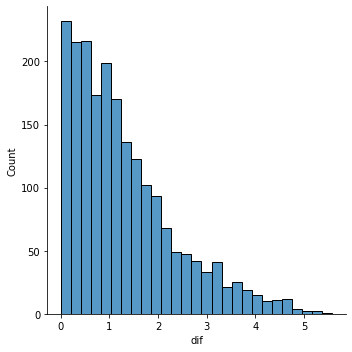

In [41]:
sns.displot(df[df.prediction == 'doublet'], x = 'dif')
plt.savefig('output.png')

In [42]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 1.2)]

In [71]:
adata = sc.read_h5ad('/nfs_master/prakrithi/abhay/testis_allfiles/GSE112013_SRR6860519_Donor1_rep1.h5ad')


In [72]:
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)

In [73]:
adata = adata[~adata.obs.doublet]


# Pre-processing

In [74]:
adata.var['mt'] = adata.var.index.str.startswith('MT-')

/home/prakrithi/miniconda3/envs/scTE2/lib/python3.7/site-packages/ipykernel_launcher.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  """Entry point for launching an IPython kernel.


In [75]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"


In [76]:
ribo_genes = pd.read_table(ribo_url, skiprows= 2, header=None)


In [80]:
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)

In [82]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
